In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
# === 1. Data Preparation ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=True,
    validation_split=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    channel_shift_range=20.0,
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 840 images belonging to 15 classes.
Found 210 images belonging to 15 classes.
Found 300 images belonging to 15 classes.


In [4]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# === 2. Load Pretrained Base Model ===
base_model = DenseNet121(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
# Unfreeze 20 layer terakhir
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# === 3. Tambahkan Custom Classifier ===
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(15, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

2025-04-26 17:55:40.336375: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-26 17:55:40.336412: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-26 17:55:40.336415: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1745664940.336940  335255 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1745664940.337303  335255 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 41s 1us/step


In [5]:
# === 4. Compile Model ===
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
# === 5. Train Model ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=35,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
    ]
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35


2025-04-26 17:56:27.439673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.0735 - loss: 4.6971 - val_accuracy: 0.0476 - val_loss: 3.2992
Epoch 2/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.0664 - loss: 4.2124 - val_accuracy: 0.0810 - val_loss: 2.9532
Epoch 3/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.0935 - loss: 3.9893 - val_accuracy: 0.1238 - val_loss: 2.8351
Epoch 4/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.1136 - loss: 3.7159 - val_accuracy: 0.2095 - val_loss: 2.6702
Epoch 5/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.1287 - loss: 3.4814 - val_accuracy: 0.1905 - val_loss: 2.5527
Epoch 6/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.1651 - loss: 3.4724 - val_accuracy: 0.2238 - val_loss: 2.4618
Epoch 7/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.1628 - loss: 3.2865 - val_accuracy: 0.2952 - val_loss: 2.3368
Epoch 8/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2160 - loss: 3.0517 - val_accuracy: 0.3333 - val_loss: 2.2006
Epo

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6820 - loss: 1.0618
Akurasi di data test: 71.33%
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step


<Figure size 1000x1000 with 0 Axes>

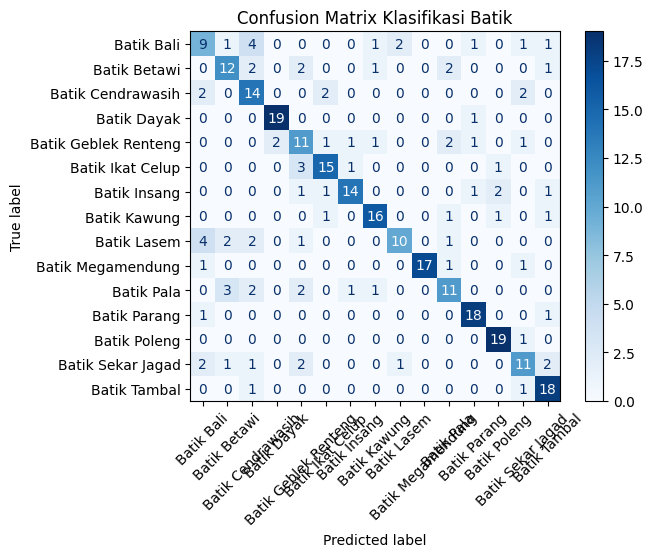

In [7]:
# === 6. Evaluate Model ===
loss, accuracy = model.evaluate(test_generator)

print(f"Akurasi di data test: {accuracy*100:.2f}%")

# === 7. Confusion Matrix ===
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(10,10))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix Klasifikasi Batik")
plt.show()

In [ ]:
from datetime import datetime

# === 10. Save Log to File ===
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Cek tren naik/turun
def trend(metric):
    return "naik" if metric[-1] > metric[0] else "turun"

# Overfitting check
overfitting = (val_acc[-1] - accuracy) > 0.1

# Catatan manual. 
note = "Densenet"

# Timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Tulis log
log_line = (
    f"{timestamp}\n"
    f"akurasi: {accuracy*100:.2f}%\n"
    f"overfitting: {overfitting}\n"
    f"accuracy: {trend(train_acc)}\n"
    f"loss: {trend(train_loss)}\n"
    f"val_accuracy: {trend(val_acc)}\n"
    f"val_loss: {trend(val_loss)}\n"
    f"perubahan: {note}\n"
    f"---\n\n"
)

In [9]:
# Hitung benar per kelas
correct_per_class = np.diag(cm)
class_info = []

for label, correct_count in zip(class_labels, correct_per_class):
    if correct_count >= 15:
        class_info.append(f"{label}: {correct_count} benar")

# Tambahkan ke log
if class_info:
    log_line += "kelas dengan ≥15 benar:\n"
    log_line += "\n".join(class_info) + "\n"
    log_line += "---\n\n"

# Simpan ke file
with open("hasil_log.txt", "a") as f:
    f.write(log_line)

In [10]:
model.save("model_batik.h5")